# MVP

In [1]:
# General Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# AWS Libraries
import logging
import boto3
from botocore.exceptions import ClientError

# NLP Libraries
import unicodedata
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud

# Geo-mapping Libraries
import geopandas
import geopy
import folium 

# Helper Functions
import MVP_acquire_ds, MVP_explore

# Skill Libray
import library

import warnings
warnings.filterwarnings("ignore")

## Data Acquisition

### Download the JSON Files from AWS S3 Bucket

In [2]:
%%time

# Create the s3 resource object
s3 = boto3.resource('s3')

# Download the json files from AWS

s3.Bucket("dspreparedjobpostings").download_file("df_ds_tx_prepared_backup.json", 
                                                 "df_ds_tx_prepared_backup.json")

s3.Bucket("wdpreparedjobpostings").download_file("df_wd_tx_prepared_backup.json", 
                                                 "df_wd_tx_prepared_backup.json")

# Print the last modified datetime of the prepared file of data scientist positions in TX
print("Last modified datetime for data scientist positions in TX: ", 
      s3.Object('dspreparedjobpostings', 'df_ds_tx_prepared_backup.json').last_modified)

# Print the last modified datetime of the prepared file of web developer positions in TX
print("Last modified datetime for web developer positions in TX: ", 
      s3.Object('wdpreparedjobpostings', 'df_wd_tx_prepared_backup.json').last_modified)

Last modified datetime for data scientist positions in TX:  2021-03-22 02:14:54+00:00
Last modified datetime for web developer positions in TX:  2021-03-22 02:17:31+00:00
CPU times: user 532 ms, sys: 285 ms, total: 817 ms
Wall time: 7.9 s


## Data Preparation

### Load JSON Files into Dataframe

In [3]:
# Read the json file into pandas dataframe

df_ds = pd.read_json('df_ds_tx_prepared_backup.json')
df_wd = pd.read_json('df_wd_tx_prepared_backup.json')

# Print the number of job postings in each dataframe

print("Number of job postings for data scientists in TX: ", df_ds.shape[0])
print("Number of job postings for web developers in TX: ", df_wd.shape[0])

Number of job postings for data scientists in TX:  3145
Number of job postings for web developers in TX:  6224


In [4]:
# Print the concise summary of the job postings for data scientists
df_ds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3145 entries, 0 to 3144
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             3145 non-null   datetime64[ns]
 1   title            3145 non-null   object        
 2   company          3145 non-null   object        
 3   company_rating   3145 non-null   float64       
 4   job_link         3145 non-null   object        
 5   job_description  3145 non-null   object        
 6   city             3145 non-null   object        
 7   state            3145 non-null   object        
 8   zipcode          3145 non-null   int64         
 9   clean            3145 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 245.8+ KB


In [5]:
# Print the most recent 5 job postings for data scientists
df_ds.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-03-21,Data Scientist,Real Estate Technology Start-up,3.77,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,We are seeking a part-time Data Scientist to j...,Austin,TX,0,seeking parttime data scientist join real esta...
1,2021-03-21,Data Scientist,Sysco,3.40,https://www.indeed.com/rc/clk?jk=22a565cb3897c...,"Company:\nUS6469 Sysco Payroll, Division of Sy...",Houston,TX,0,company us6469 sysco payroll division sysco re...
2,2021-03-21,Senior Data Scientist,Sysco,3.40,https://www.indeed.com/rc/clk?jk=529d3ec9b27c2...,"Company:\nUS6469 Sysco Payroll, Division of Sy...",Houston,TX,0,company us6469 sysco payroll division sysco re...
3,2021-03-21,Data Scientist - Statistician,Baylor College of Medicine,3.90,https://www.indeed.com/rc/clk?jk=ad8fd758fc987...,Summary\nThe Office of the Provost seeks a Sta...,Houston,TX,77030,summary office provost seek statisticiandata s...
4,2021-03-21,Data Scientist 2,PayPal,3.90,https://www.indeed.com/rc/clk?jk=e04b98828615e...,Who we are: Fueled by a fundamental belief tha...,Austin,TX,78729,fueled fundamental belief access financial ser...


In [6]:
# Print the concise summary of the job postings for web developers
df_wd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6224 entries, 0 to 6223
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             6224 non-null   datetime64[ns]
 1   title            6224 non-null   object        
 2   company          6224 non-null   object        
 3   company_rating   6224 non-null   float64       
 4   job_link         6224 non-null   object        
 5   job_description  6224 non-null   object        
 6   city             6224 non-null   object        
 7   state            6224 non-null   object        
 8   zipcode          6224 non-null   int64         
 9   clean            6224 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(7)
memory usage: 486.4+ KB


In [7]:
# Print the most recent 5 job postings for web developers
df_wd.head()

,date,title,company,company_rating,job_link,job_description,city,state,zipcode,clean
0,2021-03-21,Graphic Designer/Web Designer,Universal Flooring Supply,3.71,https://www.indeed.com/company/Universal-Floor...,Duties and ResponsibilitiesWork simultaneously...,Stafford,TX,77477,duty responsibilitieswork simultaneously 3 pro...
1,2021-03-21,Lead Application Developer- .NET,Stericycle,3.20,https://www.indeed.com/rc/clk?jk=fb6db372f7bd2...,Position Purpose:\nThis position will work wit...,North Richland Hills,TX,0,position purpose position work stericycle deve...
2,2021-03-21,Java Developer (ECDP),Apple,4.20,https://www.indeed.com/rc/clk?jk=cb20add1a40e1...,"Summary\nPosted: Mar 20, 2021\nWeekly Hours: 4...",Austin,TX,0,summary posted mar 20 2021 weekly hour 40 role...
3,2021-03-21,Software Developer ECommerce,FleetPride,3.10,https://www.indeed.com/rc/clk?jk=8f9c0407529f7...,FleetPride is the largest after-market distrib...,Irving,TX,75039,fleetpride largest aftermarket distributor hea...
4,2021-03-21,"Senior Software Engineer, Engineering Solutions",Apple,4.20,https://www.indeed.com/rc/clk?jk=8b2c14406a4c4...,"Summary\nPosted: Mar 20, 2021\nWeekly Hours: 4...",Austin,TX,0,summary posted mar 20 2021 weekly hour 40 role...


### Consolidation

In [8]:
# Create a job code column: set value 0 for data scientis and 1 for web developers

df_ds = df_ds.assign(job_code = "data scientist")
df_wd = df_wd.assign(job_code = "web developer")

# Concat the two dataframes
df = pd.concat([df_ds, df_wd])

# Inspect the new dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9369 entries, 0 to 6223
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             9369 non-null   datetime64[ns]
 1   title            9369 non-null   object        
 2   company          9369 non-null   object        
 3   company_rating   9369 non-null   float64       
 4   job_link         9369 non-null   object        
 5   job_description  9369 non-null   object        
 6   city             9369 non-null   object        
 7   state            9369 non-null   object        
 8   zipcode          9369 non-null   int64         
 9   clean            9369 non-null   object        
 10  job_code         9369 non-null   object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(8)
memory usage: 878.3+ KB


In [9]:
# Set the date as the index and sort in a descending order
df = df.set_index('date').sort_index(ascending=False)

# Rename the columns to be easily understood
df = df.rename(columns={'title': 'job_title', 'clean': 'cleaned_job_description'})

# Inspect the first 5 rows
df.head()

,job_title,company,company_rating,job_link,job_description,city,state,zipcode,cleaned_job_description,job_code
date,,,,,,,,,,
2021-03-21,Data Scientist,Real Estate Technology Start-up,3.77,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,We are seeking a part-time Data Scientist to j...,Austin,TX,0,seeking parttime data scientist join real esta...,data scientist
2021-03-21,Data Scientist,Sysco,3.40,https://www.indeed.com/rc/clk?jk=22a565cb3897c...,"Company:\nUS6469 Sysco Payroll, Division of Sy...",Houston,TX,0,company us6469 sysco payroll division sysco re...,data scientist
2021-03-21,Java Developer (ECDP),Apple,4.20,https://www.indeed.com/rc/clk?jk=cb20add1a40e1...,"Summary\nPosted: Mar 20, 2021\nWeekly Hours: 4...",Austin,TX,0,summary posted mar 20 2021 weekly hour 40 role...,web developer
2021-03-21,Software Developer ECommerce,FleetPride,3.10,https://www.indeed.com/rc/clk?jk=8f9c0407529f7...,FleetPride is the largest after-market distrib...,Irving,TX,75039,fleetpride largest aftermarket distributor hea...,web developer
2021-03-21,"Senior Software Engineer, Engineering Solutions",Apple,4.20,https://www.indeed.com/rc/clk?jk=8b2c14406a4c4...,"Summary\nPosted: Mar 20, 2021\nWeekly Hours: 4...",Austin,TX,0,summary posted mar 20 2021 weekly hour 40 role...,web developer


**Takeaways**
1. Some zipcodes are 0, which indicates they are not provided by the employers.
2. Some values in `city` column are 'Remote', which indicates the jobs do not require a specific location. 
3. So far, all the jobs are located in TX beside the remote ones and the `state` column is kept for geospacial analysis. 

### Handle Missing Values

In [10]:
# Count the missing values in each column
df.isnull().sum(axis=0)

job_title                  0
company                    0
company_rating             0
job_link                   0
job_description            0
city                       0
state                      0
zipcode                    0
cleaned_job_description    0
job_code                   0
dtype: int64

**Takeaways**: No null values has been found in the job postings. 

#### Zipcode

In [11]:
# How many zipcodes are not availabe?
df.zipcode.value_counts(normalize=True).head(1)

0    0.518732
Name: zipcode, dtype: float64

**Takeaways**
1. 52% of the zipcodes are not provided. 
2. How to handle the zipcodes with value 0?
    - option 1: drop the entire column because the ratio of the missing values is more than 50%.
    - option 2: drop the rows but we will lose half of the data. 
    - option 3: impute by the company and its location and it may need outside resource.
3. We choose to drop the `zipcode` column because our dashboard doesn't need the zipcode level of details.

In [12]:
# Drop the zipcode column

df = df.drop(columns='zipcode')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9369 entries, 2021-03-21 to 2020-12-22
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                9369 non-null   object 
 1   company                  9369 non-null   object 
 2   company_rating           9369 non-null   float64
 3   job_link                 9369 non-null   object 
 4   job_description          9369 non-null   object 
 5   city                     9369 non-null   object 
 6   state                    9369 non-null   object 
 7   cleaned_job_description  9369 non-null   object 
 8   job_code                 9369 non-null   object 
dtypes: float64(1), object(8)
memory usage: 732.0+ KB


#### City

In [13]:
# How many jobs are categorized as "Remote"?

num_remote = (df.city == 'Remote').sum()
num_jobs = df.shape[0]
print(f"{num_remote} jobs are remote, which is {round(num_remote*100/num_jobs, 1)}% of all the job postings.")

571 jobs are remote, which is 6.1% of all the job postings.


**Takeaways**: We will keep the remote jobs and compare their requirements with that of the unremote jobs.

In [14]:
# We noticed that some job titles also contains word "Remote"

mask_remote = ["Remote" in i for i in df.job_title]
print(f"{sum(mask_remote)} job titles contains word 'Remote'")
df[mask_remote].job_title.head()

262 job titles contains word 'Remote'


date
2021-03-20                     Lead Front-End Engineer (Remote)
2021-03-19    Senior Full Stack Engineer - Services and Paym...
2021-03-19                     Lead Front-End Engineer (Remote)
2021-03-19      Senior Manager, Data Science (Austin or Remote)
2021-03-19                  Data Scientist (Remote Opportunity)
Name: job_title, dtype: object

**Takeaways**: We will change their values in the city column to "Remote" and recompute the percentage of the remote jobs.

In [15]:
# Define a function to change the city in a job posting to "Remote" 
# if word "Remote" is found in the job title

def identify_remote_jobs(job_posting):
    if "Remote" in job_posting.job_title:
        job_posting.city = "Remote"
    return job_posting

In [16]:
%%time
# Change city to "Remote" if job title contains word "Remote"
df = df.apply(identify_remote_jobs, axis=1)

CPU times: user 681 ms, sys: 9.9 ms, total: 691 ms
Wall time: 692 ms


In [17]:
# How many jobs are remote after the adjustment? 
num_remote = (df.city == 'Remote').sum()
print(f"{num_remote} jobs are remote, which is {round(num_remote*100/num_jobs, 1)}% of all the job postings.")

788 jobs are remote, which is 8.4% of all the job postings.


#### Job Description

In [18]:
# How many job descriptions are missing?

num_missing = (df.job_description == 'error').sum()

print(f"{num_missing} jobs show 'error' in their descriptions, \
which is {round(num_missing*100/num_jobs, 1)}% of all the job postings.")

372 jobs show 'error' in their descriptions, which is 4.0% of all the job postings.


**Takeaways**
1. The value 'error' shows in the `job_descripion` column if the response is Nonetype when making a request to a detailed job posting page. 
2. Because only a small portion (less than 5%) are without the job description, we decide to keep those postings. 

### Clean Job Titles

In [19]:
# Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20)

Data Scientist                  329
Web Developer                   151
Software Engineer               133
Senior Data Scientist           129
Senior Software Engineer        100
Software Developer               94
Full Stack Developer             92
Java Developer                   80
Senior Data Analyst              74
Machine Learning Engineer        74
Front End Developer              72
UI Developer                     57
Sr. Data Scientist               51
Principal Data Scientist         47
PHP Developer                    47
Senior Software Developer        45
.Net Developer                   44
Web Designer                     44
Full Stack Software Engineer     44
Front End Engineer               42
Name: job_title, dtype: int64

**Takeaways**: Some senior positions use the abbreviation of senior - 'Sr.' in the job titles. We decide to use the full spelling so the 'Sr.' need to be replaced with 'Senior'.

In [20]:
# Replace 'Sr.' with 'Senior'
df.job_title = df.job_title.str.replace('Sr.', 'Senior')

# Re-Count the frequency of a job title and list the top 20
df.job_title.value_counts().head(20) 

Data Scientist                  329
Senior Data Scientist           180
Web Developer                   151
Software Engineer               133
Senior Software Engineer        123
Senior Data Analyst             113
Software Developer               94
Full Stack Developer             92
Java Developer                   80
Machine Learning Engineer        74
Front End Developer              72
UI Developer                     57
Principal Data Scientist         47
Senior Software Developer        47
PHP Developer                    47
.Net Developer                   44
Full Stack Software Engineer     44
Web Designer                     44
Front End Engineer               42
Web Designer/Developer           41
Name: job_title, dtype: int64

### Clean Company Names

In [21]:
# We noticed Amazon has three names in its job postings

amazon = df.company.str.contains("Amazon")
df[amazon].company.value_counts()

Amazon Web Services, Inc.       56
Amazon.com Services LLC         31
Amazon Dev Center U.S., Inc.     1
Name: company, dtype: int64

In [22]:
# We noticed Dell has two names in its job postings

dell = df.company.str.contains("Dell")
df[dell].company.value_counts()

Dell Technologies    89
Dell                  9
Name: company, dtype: int64

**Takeaways**
1. Although the job postings from Amazon are listed under three different company names, all of them have the same company page on Indeed - Amazon.com. We decide to give them the same company name "Amazon.com"
2. Likewise, we decide to give the job postings from Dell the same company name "Dell Technologies".

In [23]:
# Define a function to clean the company names

def clean_company_names(i):
    if "Amazon" in i:
        i = "Amazon.com"
    elif i == "Dell":
        i = "Dell Technologies"
    return i

In [24]:
# Clean the company names
df.company = df.company.apply(clean_company_names)

In [25]:
# Sanity check
df[amazon].company.value_counts()

Amazon.com    88
Name: company, dtype: int64

In [26]:
# Sanity check
df[dell].company.value_counts()

Dell Technologies    98
Name: company, dtype: int64

### Clean City Column
**Notes**: We noticed that several values in the `city` column are not cities and they are listed below
- Military posts: Fort Same Houston, Lackland AFB in San Antonio
- Metroplex: Dallas-Fort Worth
- Area: Las Colinas: an affluent and upscale area in Irving, TX. 
- Community: New York: an unincorporated community in Henderson County, TX. 

#### Military Posts

In [27]:
# How many jobs are posted from military posts?

military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

5

**Takeaways**: Only 5 jobs postings are from military posts in San Antonio. We decide to reassign them to San Antonio. 

In [28]:
# Replace military posts with the city where they are located
df.city = df.city.apply(lambda i: "San Antonio" if (i == "Fort Sam Houston") | (i == "Lackland AFB") else i)

# Sanity check
military_post = (df.city == "Fort Sam Houston") | (df.city == "Lackland AFB")
military_post.sum()

0

#### Metroplex

In [29]:
# How many jobs are posted from Dallas-Fort Forth?

metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

63

In [30]:
# How many companies posted jobsing using Dallas-Fort Worth as location?
df[metroplex].company.nunique()

23

**Takeaways** There are 8 principal cities in this metroplex and they are Dallas, Fort Worth, Arlington, Plano, Irving, Denton, Richardson, and Grapevine. We decide to reassign all of them to city Dallas. 

In [31]:
# Rename as Dallas
df.city = df.city.str.replace("Dallas-Fort Worth", "Dallas")

# Sanity check
metroplex = (df.city == "Dallas-Fort Worth")
metroplex.sum()

0

#### Area

In [32]:
# How many jobs are posted in areas?

area = (df.city == "Las Colinas") | (df.city == "New York")
area.sum()

7

**Takeaway**
1. Las Colinas is an area in Irving so we decide to replace Las Colinas with Irving.
2. We opened the job posting from New York, TX and found the employer American Express does not specify the city so we decide to assign it as Remote

In [33]:
# Replace the area names in the city column
df.city = df.city.apply(lambda i: "Irving" if i == "Las Colinas" 
                                    else ("Remote" if i == "New York" else i))

# Sanity check
area = (df.city == "Las Colinas") | (df.city == "New York")
area.sum()

0

### Handle the Reposted Jobs
**Notes**: The first step in the data cleaning in the back end has already removed the duplicated job postings based on the job title, location, company, job link and job description. The duplicates in section indicates the jobs are either reposted or the extra is needed for the same position. So far, we couldn't tell the difference between the two. We assume the majority of them are reposted. 

In [34]:
# How many jobs are reposted in the dataframe?

# Define the columns for identifying duplicates
cols = ['job_title', 'company', 'company_rating', 'job_link', 'city', 'job_code']

# Compute the number of duplicates 
num_duplicates = df.duplicated(subset=cols).sum()

print(f"{num_duplicates} jobs are reposted, \
which is {round(num_duplicates*100/num_jobs, 1)}% of all the job postings.")

2193 jobs are reposted, which is 23.4% of all the job postings.


**Takeaways**
1. Nearly one quarter of new posted jobs are acturally reposted. 
2. We decide to keep the reposts and create a new column `repost` to label each job postings so as to distinguish them. 

In [35]:
# Create a new column name `repost`

reposted = df.duplicated(subset=cols, keep="last") # Make duplicates as True except for the last occurrence
df = df.assign(repost=reposted)

# Sanity check: `repost` column has been created successfully
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9369 entries, 2021-03-21 to 2020-12-22
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   job_title                9369 non-null   object 
 1   company                  9369 non-null   object 
 2   company_rating           9369 non-null   float64
 3   job_link                 9369 non-null   object 
 4   job_description          9369 non-null   object 
 5   city                     9369 non-null   object 
 6   state                    9369 non-null   object 
 7   cleaned_job_description  9369 non-null   object 
 8   job_code                 9369 non-null   object 
 9   repost                   9369 non-null   bool   
dtypes: bool(1), float64(1), object(8)
memory usage: 741.1+ KB


In [36]:
# Save as csv file to visualize the brief summary of the job market in 2021

# Define the cols to drop
cols = ['job_link', 'job_description', 'cleaned_job_description']

# Save the job postings in 2021
df.drop(columns=cols).loc["2021"].to_csv("joint_job_postings.csv")

## Data Exploration

### Summary of the Job Market in 2021

In [46]:
# How many jobs are posted in 2021?

df_2021 = df.loc["2021"]
print(f"{df_2021.shape[0]} jobs are posted in 2021 for data scientists and web developers in TX.")

8894 jobs are posted in 2021 for data scientists and web developers in TX.


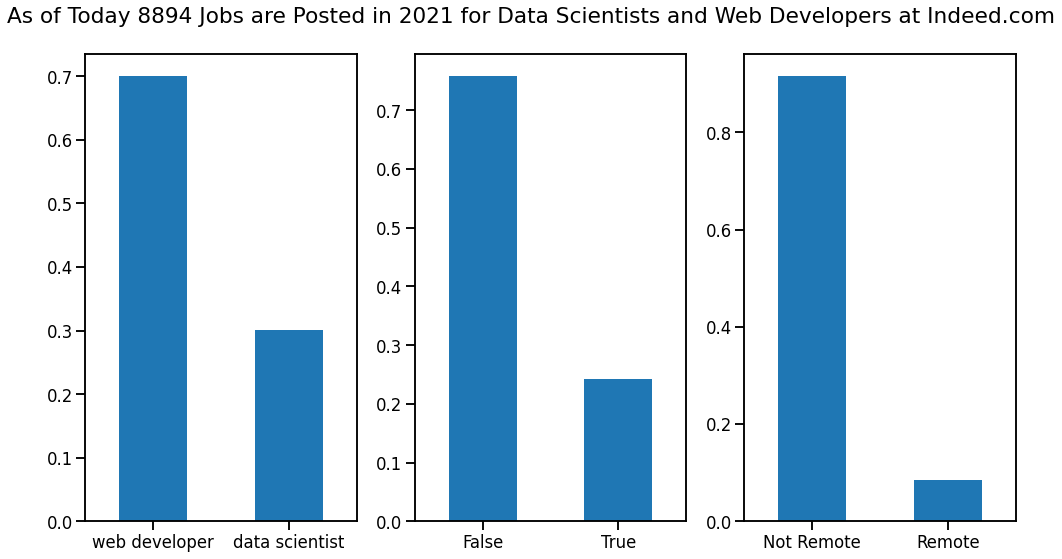

In [137]:
# Set the plotting context parameters
sns.set_context('talk')

fig, axes = plt.subplots(1,3,figsize=(14,8))

df_2021.job_code.value_counts(normalize=True).plot(kind='bar', ax=axes[0], rot="0")
df_2021.repost.value_counts(normalize=True).plot(kind='bar', ax=axes[1], rot="0")
df_2021.city.apply(lambda i: i if i == "Remote" 
                   else "Not Remote").value_counts(normalize=True).plot(kind='bar', ax=axes[2], rot="0")

fig.suptitle("As of Today 8894 Jobs are Posted in 2021 for Data Scientists and Web Developers at Indeed.com")

plt.tight_layout()
plt.show()

**Takeaways**
1. As of today, 8894 jobs have been posted in TX for data scientists and web developers. 
2. About 70% of the jobs are for web developers and 30% for data scientists.
3. Nealry 25% of the jobs are reposted and 8.5% of jobs are remote.

### Where Are the Jobs - Geospatial Analysis

In [119]:
# Remove the remote jobs in 2021

not_remote = (df_2021.city != "Remote")
df_2021_not_remote = df_2021[not_remote]

# Print the number of non-remote jobs
df_2021_not_remote.shape

(8138, 10)

In [141]:
# List the top 10 cities of the highest demand

top10_cities = pd.concat([df_2021_not_remote.city.value_counts().head(10),
                          df_2021_not_remote.city.value_counts(normalize=True).head(10),
                          df_2021_not_remote.city.value_counts(normalize=True).cumsum().head(10)], axis=1)

top10_cities.columns = ['number_of_jobs', 'percent_of_total', 'cumulative_percent_to_total']

top10_cities

,number_of_jobs,percent_of_total,cumulative_percent_to_total
Austin,2656,0.326370,0.326370
Dallas,1332,0.163677,0.490047
Houston,981,0.120546,0.610592
Plano,723,0.088842,0.699435
San Antonio,478,0.058737,0.758172
Irving,407,0.050012,0.808184
Fort Worth,212,0.026051,0.834234
Richardson,148,0.018186,0.852421
Round Rock,87,0.010691,0.863111
Frisco,71,0.008725,0.871836


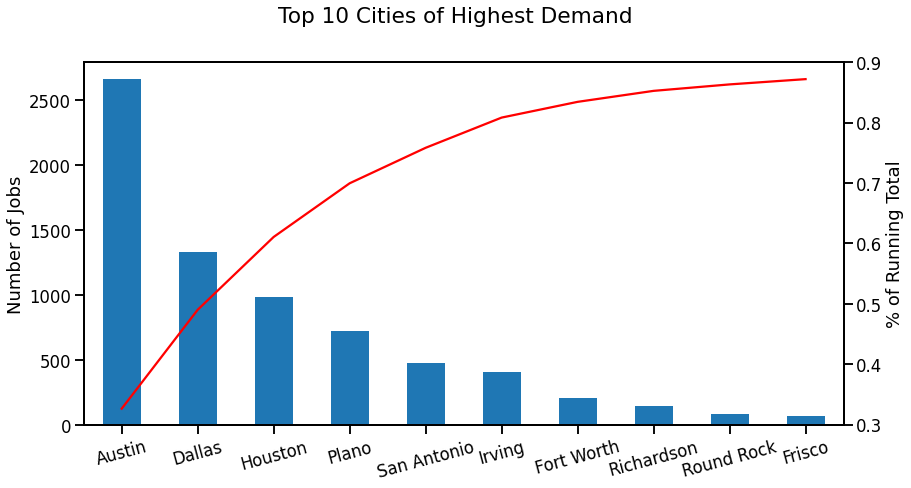

In [139]:
# Visualize the top10 cities by Pareto chart

fig, ax1 = plt.subplots(figsize=(13,7))

# Create a secondary y-axis
ax2 = ax1.twinx()

top10_cities.percent_of_total.plot(kind='bar', ax=ax1, rot='15')
top10_cities.cumulative_percent_to_total.plot(ax=ax2, color='r')

fig.suptitle("Top 10 Cities of Highest Demand")

ax1.set_ylabel("Number of Jobs")
ax2.set_ylabel("% of Running Total")

ax2.set_yticks([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

plt.tight_layout()
plt.show()

**Takeaways**
1. About 1/3 of jobs are from companies located in Austin. 
2. The top 10 cities together provide almost 90% of the jobs in the job market in 2021. 

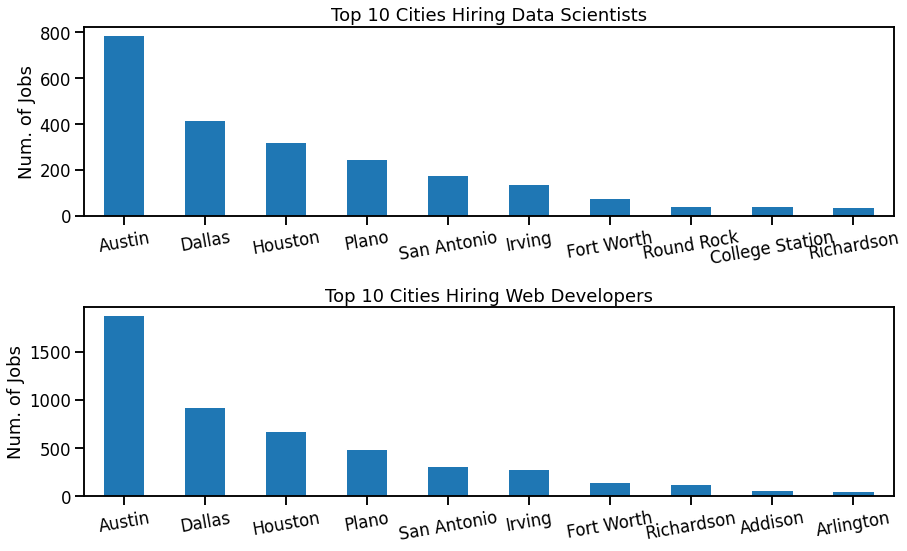

In [142]:
# Compare the top 10 cities that hire data scientists and web developers

# Create a figure and two subplots
fig, axes = plt.subplots(2,1,figsize=(13,8))

df_2021_not_remote_ds = df_2021_not_remote[df_2021_not_remote.job_code == "data scientist"]
df_2021_not_remote_wd = df_2021_not_remote[df_2021_not_remote.job_code == "web developer"]

df_2021_not_remote_ds.city.value_counts().head(10).plot(kind='bar', rot='10', ax=axes[0])
df_2021_not_remote_wd.city.value_counts().head(10).plot(kind='bar', rot='10', ax=axes[1])


# Create the titles
axes[0].set_title("Top 10 Cities Hiring Data Scientists")
axes[1].set_title("Top 10 Cities Hiring Web Developers")

# Create y labels
axes[0].set_ylabel("Num. of Jobs")
axes[1].set_ylabel("Num. of Jobs")

plt.tight_layout()
plt.show()

**Takeaways**:
1. The top 7 cities that hire data scientists are Austin, Dallas, Houston, Plano, San Antonio, Irving, and Fort Worth and it is the exactly the same 7 cities taht hire web developers.
2. The top 7 cities together contributes to 83% of the jobs in the market.

#### Data Scientist Position

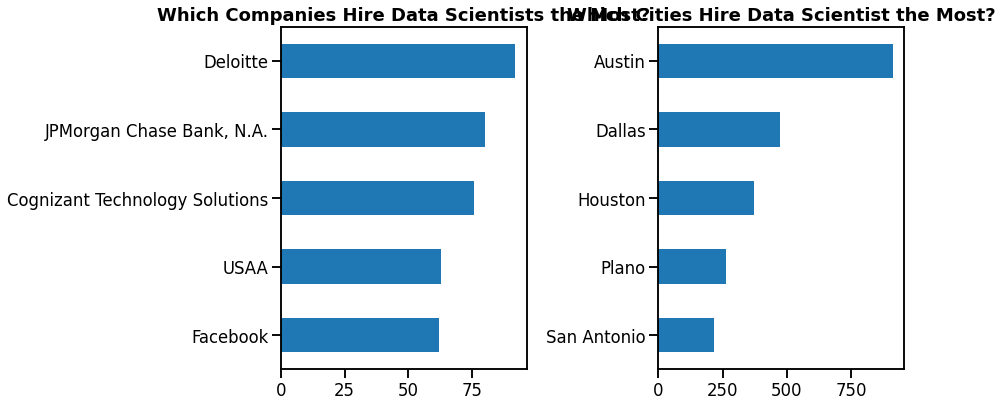

In [59]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts


plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_ds.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Data Scientists the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_ds.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Data Scientist the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [9]:
# How does the number of job postings change over time?
df_ds.resample('W').title.count()

date
2020-12-27    392
2021-01-03    136
2021-01-10    212
2021-01-17    187
2021-01-24    352
2021-01-31    295
2021-02-07    269
2021-02-14    305
2021-02-21    185
2021-02-28    235
2021-03-07    232
2021-03-14     97
Freq: W-SUN, Name: title, dtype: int64

In [10]:
# Which company has the best avereage rating? 
df_ds.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Digital Pharmacist    5.0
Rekruiters            5.0
Onit                  4.7
Levelset              4.7
Harnham               4.6
Name: company_rating, dtype: float64

In [11]:
df_ds.title.value_counts().head()

Data Scientist               306
Senior Data Scientist        115
Senior Data Analyst           66
Machine Learning Engineer     60
Sr. Data Scientist            48
Name: title, dtype: int64

#### Web Developer Position

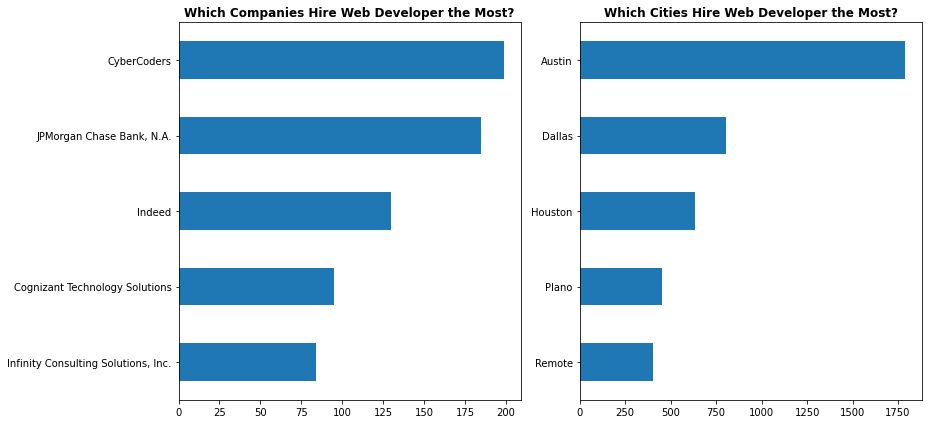

In [12]:
# Barplot the top 5 companies and top 5 cities by the number of the job posts

plt.figure(figsize=(13,6))

plt.subplot(121)
top_companies = df_wd.company.value_counts().head(5)
top_companies.sort_values().plot(kind='barh')
plt.title("Which Companies Hire Web Developer the Most?", fontweight='bold')

plt.subplot(122)
top_cities = df_wd.city.value_counts().head(5)
top_cities.sort_values().plot(kind='barh')
plt.title("Which Cities Hire Web Developer the Most?", fontweight='bold')

plt.tight_layout()
plt.show()

In [13]:
# How does the number of job postings change over time?
df_wd.resample('W').title.count()

date
2021-01-10      62
2021-01-17     346
2021-01-24     793
2021-01-31    1054
2021-02-07     825
2021-02-14     786
2021-02-21     452
2021-02-28     520
2021-03-07     542
2021-03-14     347
Freq: W-SUN, Name: title, dtype: int64

In [14]:
# Which company has the best avereage rating? 
df_wd.groupby('company').company_rating.mean().sort_values(ascending=False).head()

company
Givelify                        5.0
ALAANT                          5.0
MPIRE Technology Group, Inc.    5.0
RightNow Ministries             5.0
Royal & Ross                    5.0
Name: company_rating, dtype: float64

In [15]:
df_wd.title.value_counts().head()

Web Developer               138
Software Engineer           127
Software Developer           92
Senior Software Engineer     88
Full Stack Developer         86
Name: title, dtype: int64

### Top k Needed Skills

#### Data Scientist Position
- Tech Skills
- Soft Skills
- General Skills (Combination of Tech+Soft)

In [16]:
# Import library
ds_tech_library = library.library_ds_tech

# Print the number of skills in the library
print("Number of data science skills in tech skill library: ", len(ds_tech_library))

# Print the top 5 needed tech skills

ds_top_tech = MVP_explore.top_skills(df_ds, 5, ds_tech_library, 'tech')
ds_top_tech

Number of data science skills in tech skill library:  71
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_tech_skills,frequency
0,machine learning,4368.0
1,python,2361.0
2,sql,1762.0
3,aws,1417.0
4,r,1297.0


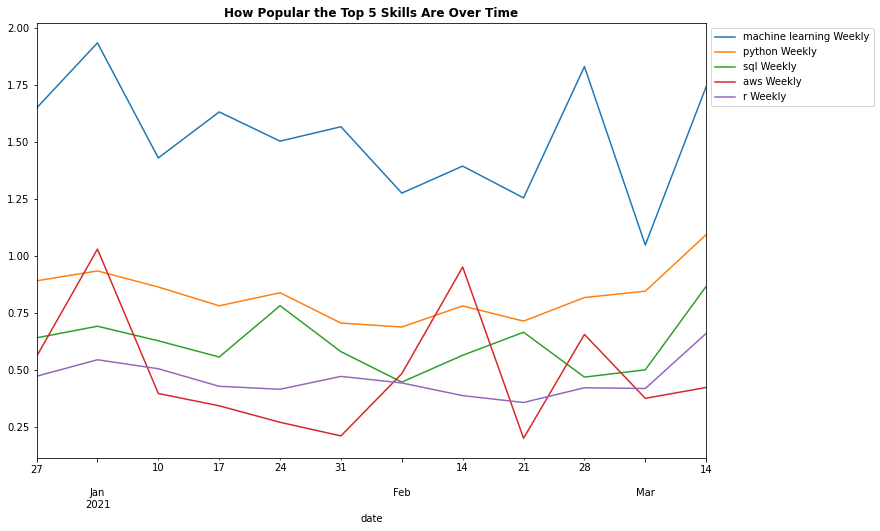

In [17]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_tech)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_tech)

In [18]:
# Import library
ds_soft_library = library.library_ds_soft

# Print the number of skills in the library
print("Number of data science skills in soft skill library: ", len(ds_soft_library))

# Print the top 5 needed soft skills

ds_top_soft = MVP_explore.top_skills(df_ds, 5, ds_soft_library, 'soft')
ds_top_soft

Number of data science skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_soft_skills,frequency
0,communication,1972.0
1,leadership,1312.0
2,collaboration,572.0
3,problem solving,426.0
4,written communication,330.0


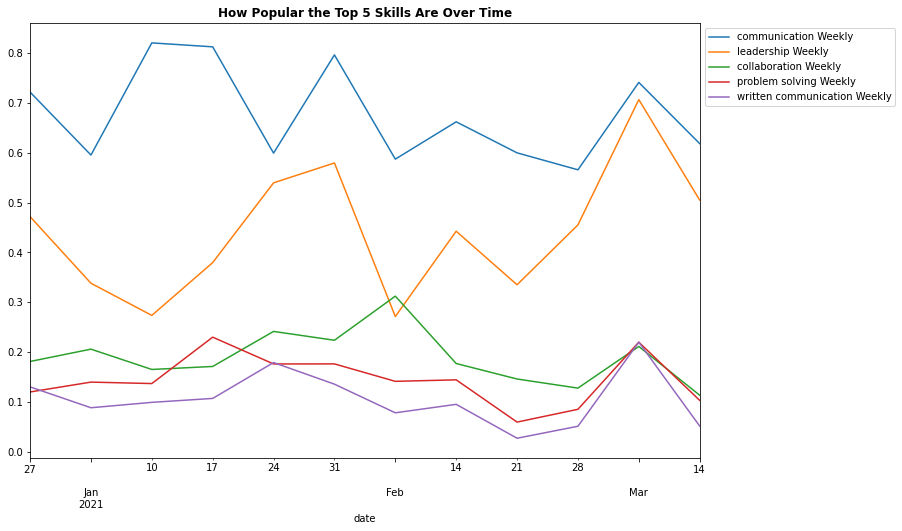

In [19]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_soft)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_soft)

In [20]:
# Import library
ds_general_library = library.library_ds_general

# Print the number of skills in the library
print("Number of data science skills in general skills library: ", len(ds_general_library))

# Print the top 5 needed general skills

ds_top_general = MVP_explore.top_skills(df_ds, 5, ds_general_library, 'general')
ds_top_general

Number of data science skills in general skills library:  90
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
ds


,top5_general_skills,frequency
0,machine learning,4368.0
1,python,2361.0
2,communication,1972.0
3,sql,1762.0
4,aws,1417.0


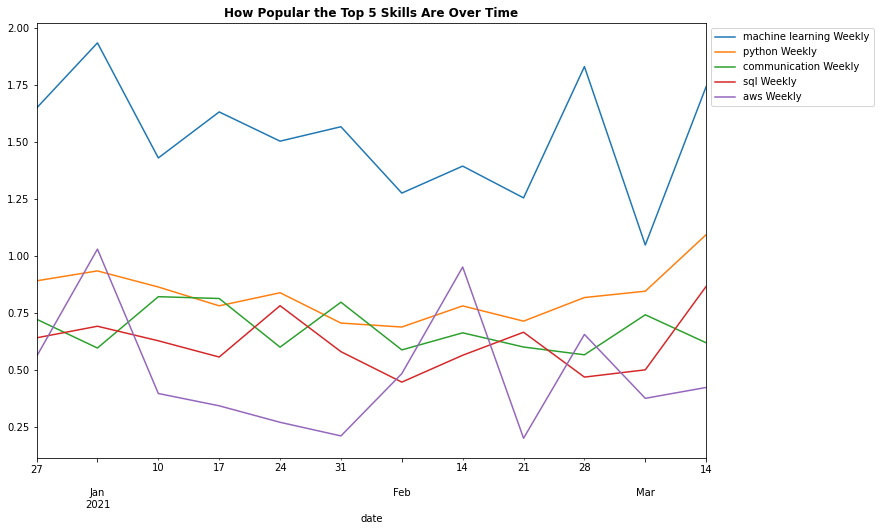

In [21]:
# Plot the how the frequency of the skills per observation change over time

df_ds_skills = MVP_explore.add_skill_frequency(df_ds, ds_top_general)
MVP_explore.plot_top_skill_ts(df_ds_skills, ds_top_general)

#### Web Developer Position
- Tech skills
- Soft skills
- General Skills (Combination of Tech+Soft)

In [22]:
# Import library
wd_tech_library = library.library_wd_tech

# Print the number of skills in the library
print("Number of web dev skills in tech skill library: ", len(wd_tech_library))

# Print the top 5 needed tech skills

wd_top_tech = MVP_explore.top_skills(df_wd, 5, wd_tech_library, 'tech')
wd_top_tech

Number of web dev skills in tech skill library:  67
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_tech_skills,frequency
0,javascript,4511.0
1,java,3037.0
2,sql,2741.0
3,react,2438.0
4,c,2263.0


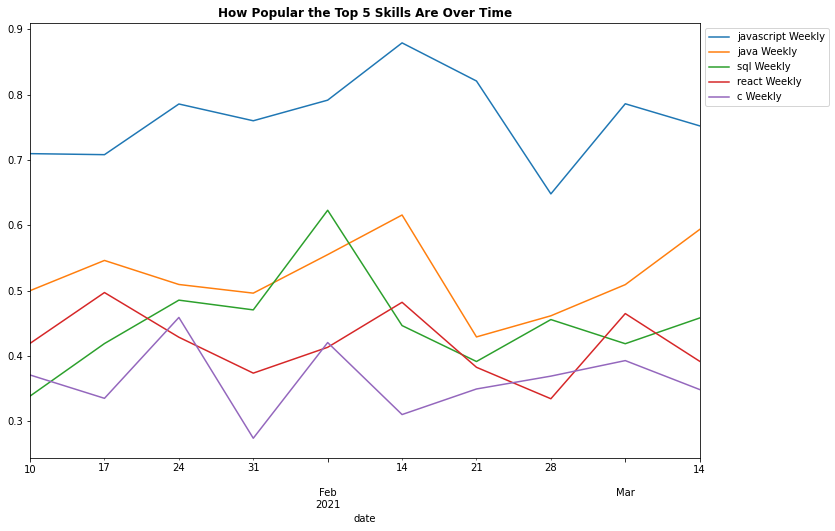

In [23]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_tech)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_tech)

In [24]:
# Import library
wd_soft_library = library.library_wd_soft

# Print the number of skills in the library
print("Number of web dev skills in soft skill library: ", len(wd_soft_library))

# Print the top 5 needed soft skills

wd_top_soft = MVP_explore.top_skills(df_wd, 5, wd_soft_library, 'soft')
wd_top_soft

Number of web dev skills in soft skill library:  20
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_soft_skills,frequency
0,communication,3365.0
1,leadership,1306.0
2,collaboration,896.0
3,problem solving,711.0
4,written communication,504.0


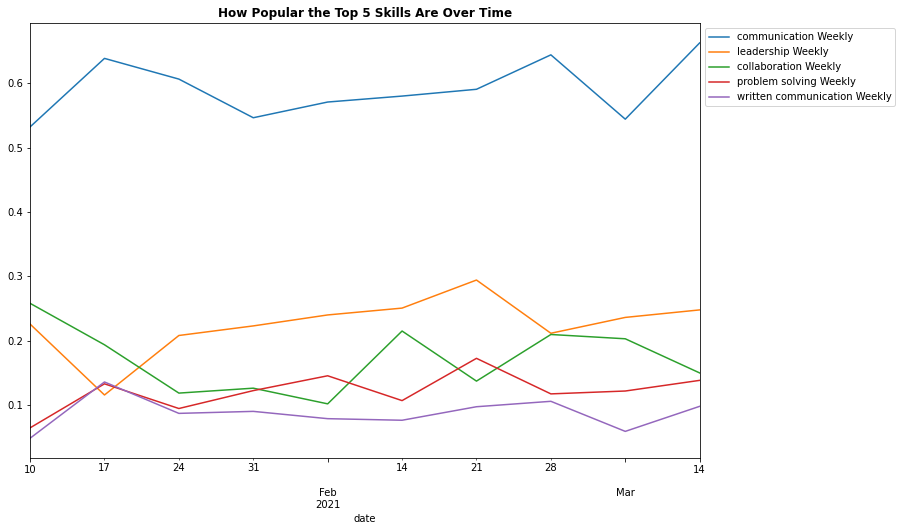

In [25]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_soft)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_soft)

In [26]:
# Import library
wd_general_library = library.library_wd_general

# Print the number of skills in the library
print("Number of web dev skills in general skill library: ", len(wd_general_library))

# Print the top 5 needed general skills

wd_top_general = MVP_explore.top_skills(df_wd, 5, wd_general_library, 'general')
wd_top_general

Number of web dev skills in general skill library:  86
Do you want to save the dataframe as JSON and upload to AWS? (Y/N)
y
Enter the INITIALS of the job title:
wd


,top5_general_skills,frequency
0,javascript,4511.0
1,communication,3365.0
2,java,3037.0
3,sql,2741.0
4,react,2438.0


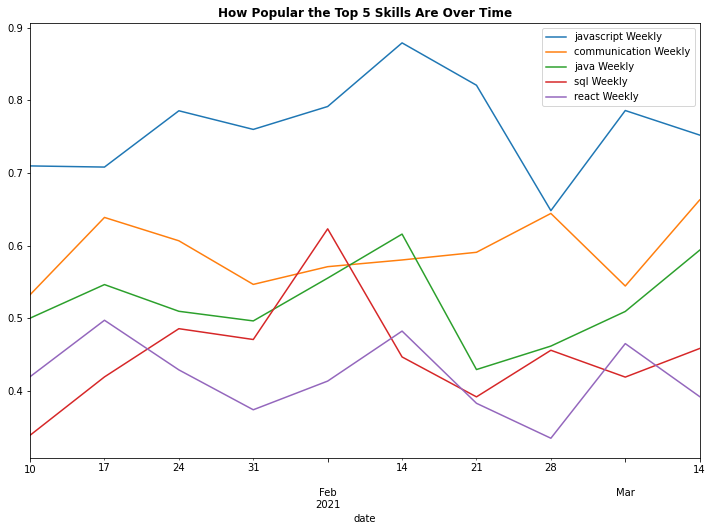

In [27]:
# Plot the how the frequency of the skills per observation change over time

df_wd_skills = MVP_explore.add_skill_frequency(df_wd, wd_top_general)
MVP_explore.plot_top_skill_ts(df_wd_skills, wd_top_general)